# Proyecto final: Elisa & Isabel

# **Bank Churn Prediction**

Antes de nada, importamos las librerías necesarias:

In [1]:
import requests
import pandas as pd
from io import StringIO
import time 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest, chi2

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score

In [2]:
import warnings

warnings.filterwarnings("ignore")

### Planteamiento del problema y recopilación de datos

Con este Dataset descargado de Kaggle, queremos analizar el abandono bancario y, en sucesivas fases, poder entrenar un modelo de Machine Learning para responder a la pregunta: "¿Qué tipo de cliente tiene más probabilidad de abandonar/cambiar una entidad bancaria?". Por lo tanto, encontramos que el dataset del que disponemos puede ayudarnos a resolver la cuestión planteada y aplicamos un proceso de EDA para conocerlo con más en detalle.


Importaremos el conjunto de datos para comenzar a trabajar con él:

In [3]:
url="/workspaces/Isa-Project/data/friance new.csv"
data_raw=pd.read_csv(url)

#observamos que se hayan cargado correctamente los datos con las primeras 5 filas del dataset
data_raw.head()

,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,...,France,Germany,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,2023,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,...,1,0,0,0,1,0.0,0.0,0.0,"9.090.909.090.909.090,00",99.0
1,2024,627.0,33.0,1.0,0.00,2.0,1,1,49503.5,0,...,1,0,0,0,1,2.0,0.0,0.0,"30.303.030.303.030.300,00",33.0
2,1236,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,...,1,0,0,0,1,0.0,0.0,0.0,0.25,400.0
3,1362,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,...,1,0,0,0,1,1.0,"10.229.405.812.711.500,00","17.606.550.452.171.200,00","58.823.529.411.764.700,00",68.0
4,491,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,...,0,0,1,0,1,2.0,0.0,0.0,"15.151.515.151.515.100,00",165.0


Vamos a echar un vistazo al número de datos, valores no nulos y tipo de datos de cada columna (lo utilizaremos posteriormente para el EDA)

In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175028 entries, 0 to 175027
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Surname             175028 non-null  int64  
 1   CreditScore         175028 non-null  float64
 2   Age                 175028 non-null  float64
 3   Tenure              175028 non-null  float64
 4   Balance             175028 non-null  float64
 5   NumOfProducts       175028 non-null  float64
 6   HasCrCard           175028 non-null  int64  
 7   IsActiveMember      175028 non-null  int64  
 8   EstimatedSalary     175028 non-null  object 
 9   Exited              175028 non-null  int64  
 10  Surname_tfidf_0     175028 non-null  object 
 11  Surname_tfidf_1     175028 non-null  object 
 12  Surname_tfidf_2     175028 non-null  object 
 13  Surname_tfidf_3     175028 non-null  object 
 14  Surname_tfidf_4     175028 non-null  object 
 15  France              175028 non-nul

Duplicados y nulos: analizamos cuántos duplicados hay (y, de habérlos los eliminamos) y los nulos para tomar una decisión sobre ellos:

In [5]:
print(f"Duplicados: {data_raw.duplicated().sum()} Como existen duplicados, los eliminamos")
data_raw.drop_duplicates(inplace=True)
print(f"Comprobamos que ya no existen duplicados: {data_raw.duplicated().sum()}")

print(f"Nulos:\n{data_raw.isna().sum()} \n\nNo existen nulos en ninguna variable")

Duplicados: 41 Como existen duplicados, los eliminamos
Comprobamos que ya no existen duplicados: 0
Nulos:
Surname               0
CreditScore           0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Surname_tfidf_0       0
Surname_tfidf_1       0
Surname_tfidf_2       0
Surname_tfidf_3       0
Surname_tfidf_4       0
France                0
Germany               0
Spain                 0
Female                0
Male                  0
Mem__no__Products     0
Cred_Bal_Sal          0
Bal_sal               0
Tenure_Age            0
Age_Tenure_product    0
dtype: int64 

No existen nulos en ninguna variable


Vamos a realizar el EDA:

**Descripción de las variables:**

* **Surname** Apellido del cliente.- **Tipo**: int 

* **CreditScore** Puntuación de crédito, una medida de la solvencia crediticia. **Tipo**: float

* **Age** Edad del cliente. **Tipo**: float

* **Tenure** Número de años que el cliente ha sido cliente del banco. **Tipo**: float

* **Balance** Saldo de la cuenta del cliente. **Tipo**: float

* **NumOfProducts** Número de productos financieros que el cliente tiene con el banco. **Tipo**: float

* **IsActiveMember** Indica si el cliente es miembro activo (1 si lo es, 0 si no). **Tipo**: int

* **HasCrCard** Indica si el cliente tiene una tarjeta de crédito (1 si tiene, 0 si no). **Tipo**: int

* **EstimatedSalary** Salario estimado del cliente. **Tipo**: object - ***transformar***

* **Surname_tfidf_0 a Surname_tfidf_4** Características de procesamiento de texto (TF-IDF) derivadas del apellido del cliente. **Tipo**: object

* **France, Germany, Spain**: Variables dummy que indican la nacionalidad del cliente. **Tipo**: int

* **Female, Male** Variables dummy que indican el género del cliente. **Tipo**: int

* **Exited** Variable objetivo, indica si el cliente ha abandonado el servicio (1, 0 no). **Tipo**: int


**Las siguientes variables, pueden representar la relación entre variables arriba descritas, debemos analizar bien esa relación (posteriormente en el EDA lo vemos):**

* **Mem__no__Products** Una característica derivada que puede representar la relación entre el número de productos y la membresía activa. **Tipo**: float

* **Cred_Bal_Sal** Una característica derivada que puede representar la relación entre el puntaje de crédito, el saldo y el salario estimado. **Tipo**: object - ***transformar***

* **Bal_sal** Una característica derivada que puede representar la relación entre el saldo y el salario estimado. **Tipo**: object - ***transformar***

* **Tenure_Age** Una característica derivada que puede representar la relación entre la antigüedad y la edad del cliente. **Tipo**: object - ***transformar***

* **Age_Tenure_product** Una característica derivada que puede representar la relación entre la edad, la antigüedad y el número de productos. **Tipo**: float


#### Eliminar información irrelevante

Cuando queremos preparar los datos para entrenar un modelo predictivo debemos responder a la siguiente pregunta: ¿son todas
las características imprescindibles para realizar una predicción? 

Normalmente, esa pregunta es un rotundo no. Tenemos que tratar de ser lo más objetivos posibles y llevar a cabo este proceso previo antes de la fase de selección de características. Por lo tanto,
aquí lo que trataremos de hacer es una eliminación controlada de aquellas variables que podemos prever que el algoritmo no va a utilizar en el proceso predictivo, o que no veamos que tengan mucha relevancia con respecto a la variable objetivo. 

En este caso, estas son las variables relacionadas con el apellido: 'Surname', 'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2', 'Surname_tfidf_3' y 'Surname_tfidf_4' ya que nuestra variable objetivo es la baja del banco, en lo que el apellido no debe influir. 

In [6]:
data_clean=data_raw.drop(['Surname', 'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2', 'Surname_tfidf_3', 'Surname_tfidf_4'], axis = 1, inplace = False)
data_clean.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,1,0,0,0,1,0.0,0.0,0.0,"9.090.909.090.909.090,00",99.0
1,627.0,33.0,1.0,0.00,2.0,1,1,49503.5,0,1,0,0,0,1,2.0,0.0,0.0,"30.303.030.303.030.300,00",33.0
2,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,1,0,0,0,1,0.0,0.0,0.0,0.25,400.0
3,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,1,0,0,0,1,1.0,"10.229.405.812.711.500,00","17.606.550.452.171.200,00","58.823.529.411.764.700,00",68.0
4,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,0,0,1,0,1,2.0,0.0,0.0,"15.151.515.151.515.100,00",165.0


Vamos a analizar la **variable objetivo** *EXITED* por sí sola, para ver desbalanceos también

In [7]:
y=data_raw["Exited"]
print(y.describe())
print(pd.DataFrame({
    'Counts': y.value_counts(),
    'Proportion': y.value_counts() / len(y)
}))

count    174987.000000
mean          0.211176
std           0.408144
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Exited, dtype: float64
        Counts  Proportion
Exited                    
0       138034    0.788824
1        36953    0.211176


Tenemos suficientes "éxitos" (abandonos) 36953 (un 21,11%), hay que tener en cuenta estas estadísticas a la hora de coger la muestra de entrenamiento y test para validar que cumplan con las mismas proporciones.

De cara a reducir el dataset, vamos a agrupar las variables que se refieren al mismo tema:

* **Male/Female** en una sola: *Sex*
* **France/Germany/Spain** en *Countries*


In [8]:
data_clean["Sex"]=data_raw["Male"]

data_clean['Countries'] = data_raw['France'] * 1 + data_raw['Germany'] * 2 + data_raw['Spain'] * 3

# Mostrar el DataFrame resultante
data_clean.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,...,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product,Sex,Countries
0,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,1,...,0,0,1,0.0,0.0,0.0,"9.090.909.090.909.090,00",99.0,1,1
1,627.0,33.0,1.0,0.00,2.0,1,1,49503.5,0,1,...,0,0,1,2.0,0.0,0.0,"30.303.030.303.030.300,00",33.0,1,1
2,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,1,...,0,0,1,0.0,0.0,0.0,0.25,400.0,1,1
3,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,1,...,0,0,1,1.0,"10.229.405.812.711.500,00","17.606.550.452.171.200,00","58.823.529.411.764.700,00",68.0,1,1
4,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,0,...,1,0,1,2.0,0.0,0.0,"15.151.515.151.515.100,00",165.0,1,3


Comprobamos las variables creadas:

[]

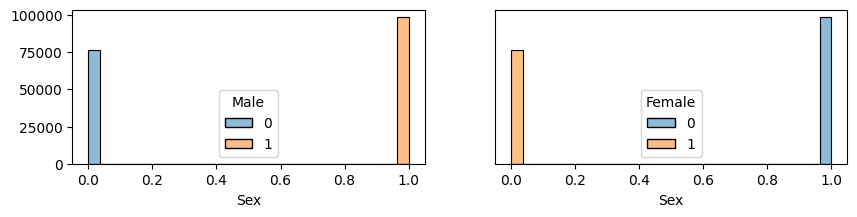

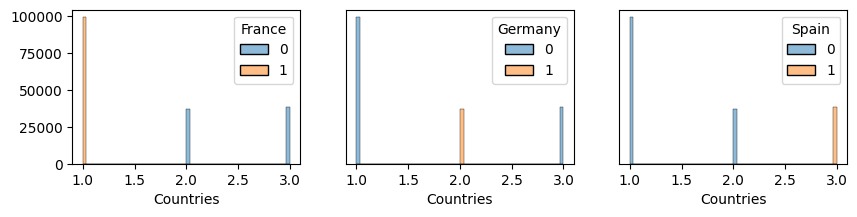

In [9]:
fig, axis= plt.subplots(1,2, figsize=(10,2))
sns.histplot(ax=axis[0], data = data_clean, x = "Sex",hue="Male").set(ylabel = None)
axis[1].set_yticks([])
sns.histplot(ax=axis[1], data = data_clean, x = "Sex",hue="Female").set(ylabel = None)

fig, axis= plt.subplots(1,3, figsize=(10,2))
sns.histplot(ax=axis[0], data = data_clean, x = "Countries",hue="France").set(ylabel = None)
sns.histplot(ax=axis[1], data = data_clean, x = "Countries",hue="Germany").set(ylabel = None)
axis[2].set_yticks([])
sns.histplot(ax=axis[2], data = data_clean, x = "Countries",hue="Spain").set(ylabel = None)
axis[1].set_yticks([])

Están correctas las variables: 

* Sex=0 son las mujeres (Female) y Sex=1 son los hombres (Male)

* Countries=1 es France, Countries=2 es Germany y Countries=3 es Spain  


Mantenemos sólo Sex y Countries:

In [10]:
data_clean.drop(["Male","Female","Germany","Spain","France"],axis=1,inplace=True)
data_clean.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product,Sex,Countries
0,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,0.0,0.0,0.0,"9.090.909.090.909.090,00",99.0,1,1
1,627.0,33.0,1.0,0.00,2.0,1,1,49503.5,0,2.0,0.0,0.0,"30.303.030.303.030.300,00",33.0,1,1
2,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,0.0,0.0,0.0,0.25,400.0,1,1
3,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,1.0,"10.229.405.812.711.500,00","17.606.550.452.171.200,00","58.823.529.411.764.700,00",68.0,1,1
4,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,2.0,0.0,0.0,"15.151.515.151.515.100,00",165.0,1,3


Vamos a analizar las variables por separado primero (Age, Tenure, NumOfProducts, IsActiveMember, Sex), y después analizaremos las que parecen ser una combinación de otras (Tenure_Age,Age_Tenure_product,Mem__no__Products)

**1. Análisis variables independientes: Age, Tenure, NumOfProducts, IsActiveMember, Sex**

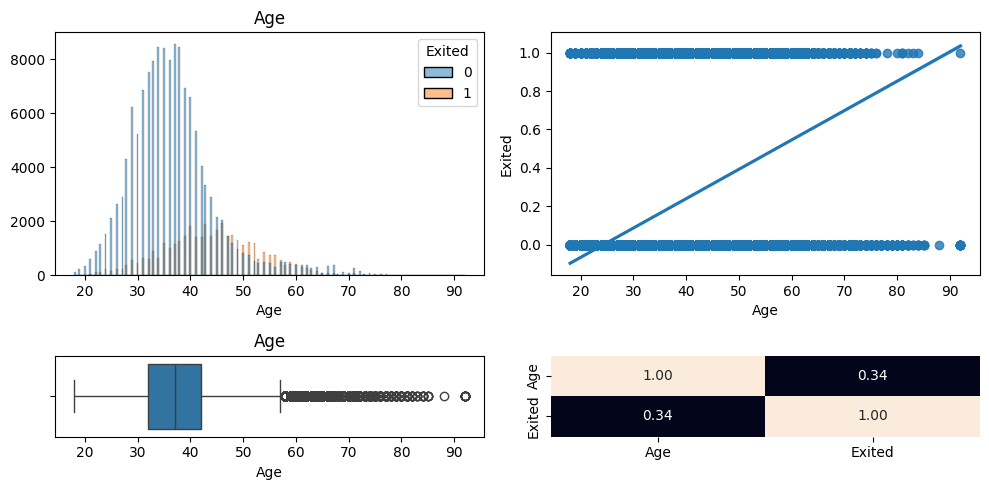

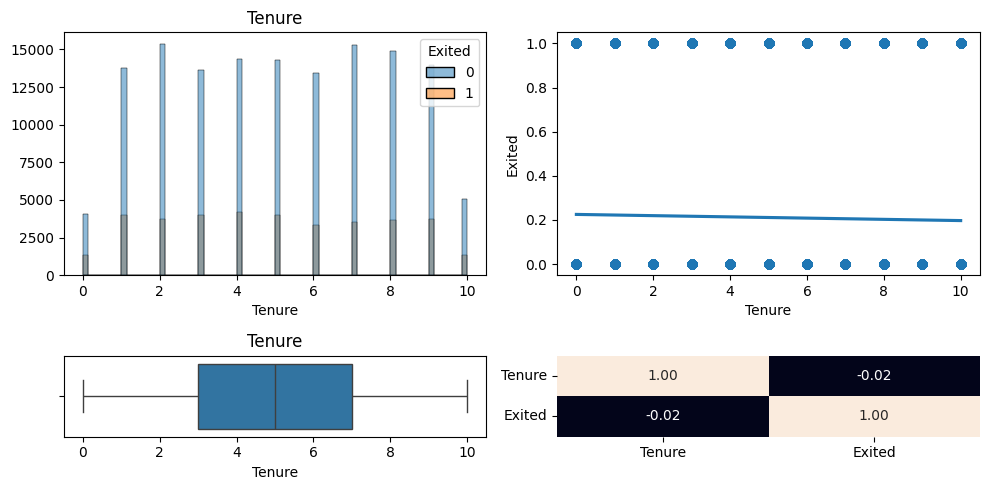

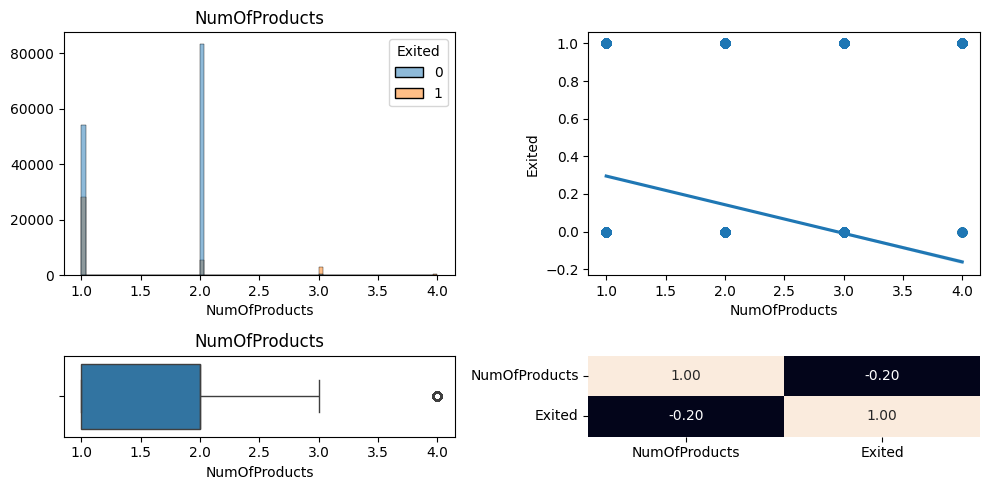

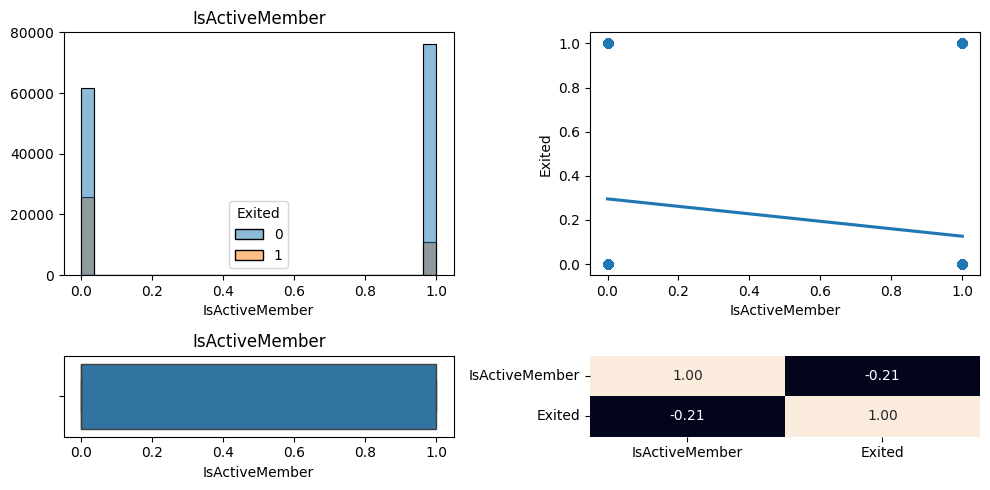

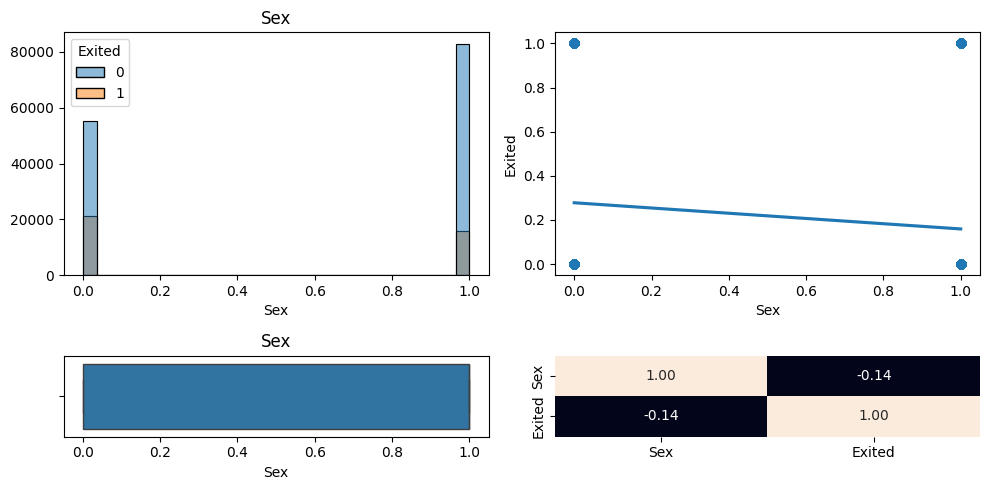

In [11]:
vars=["Age","Tenure","NumOfProducts","IsActiveMember","Sex"]
for i in range(len(vars)):
    var=vars[i]
    fig, axis = plt.subplots(2, 2, figsize = (10,5),gridspec_kw={'height_ratios': [3, 1]})
    axis[0,0].set_title(var)
    sns.histplot(ax=axis[0,0], data = data_clean, x = var,hue="Exited").set(ylabel = None)
    axis[1,0].set_title(var)
    sns.regplot(data = data_clean, x = var, y = "Exited",ax=axis[0,1])
    sns.boxplot(ax = axis[1,0], data = data_clean, x = var)
    sns.heatmap(data_clean[[var, "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,1])
    plt.tight_layout()
    plt.show()

**ANALISIS DE LAS VARIABLES ARRIBA GRAFICADAS**

**AGE**

La variable edad concentra los atípicos en los valores altos de la variable  (por encima de los 60 años), sin embargo, podemos observar en el histograma, que en esos valores es donde se concentra el mayor porcentaje de abandonos (churn, nuestra variable objetivo *Exited*), lo que es corroborado también por la correlación positiva de 0.34 con la variable *Exited*. Por tanto, no vamos a tratar los outliers de la variable edad, y es una candidata a entrar en el modelo.

**TENURE**

La variable antigüedad, no contiene atípicos, es bastante uniforme y, además, vemos que no existe correlación ni visual (histograma) ni después en la correlación de -0.02. Esta variable es candidata a *NO* entrar en el modelo.

**NUMOFPRODUCTS**

La variable número de productos, vemos que tiene sólo 4 valores, de esos, más del 75% de los datos se concentran entre el valor 1 y 2, en la *Tabla1* vemos que el 3 concentra sólo el 1% de los datos y el 4 el 0,3%. Por tanto, no podemos tomar como significativos los % de abandono que aparecen en esos bloques. Sin embargo, sí que vemos en el histograma, que para el valor 1 el % de abandono es mucho mayor que para el valor 2. Esto también se comprueba con la correlación negativa -0.20. Esta variable es candidata a entrar en el modelo.

**ISACTIVEMEMBER**

La variable miembro activo, dicotómica, nos muestra que también tiene una correlación negativa con nuestra variable objetivo, siendo -0.21 la correlación, y visualmente podemos comprobar que el % de abandono es mayor en el valor 0 que en el 1 (miembro activo). Esta variable es candidata a entrar en el modelo.

**SEX**

La variable sexo, nos indica que, mientras que el banco tiene un mayor número de hombres (56%) (ver *Tabla2*), el % de abandono es mayor en las mujeres (28% vs 16%). Lo cual se comprueba con una correlación negativa (1 son hombres) con nuestra variable objetivo de -0.14. Esta variable es candidata a entrar en el modelo.



Tabla 1: Comprobamos la distribución de la variable NumOfProducts

In [12]:
print(pd.DataFrame({
    'Counts': data_clean["NumOfProducts"].value_counts(),
    'Proportion': data_clean["NumOfProducts"].value_counts() / len(y)
}))

               Counts  Proportion
NumOfProducts                    
2.0             88853    0.507769
1.0             82440    0.471121
3.0              3159    0.018053
4.0               535    0.003057


Tabla2: Porcentaje Hombres-Mujeres frente a % Churn de cada sexo:

In [13]:
percentaje=(data_clean.groupby('Sex')['Exited'].count()/len(data_clean['Exited']))*100
churn=(data_clean.groupby("Sex")["Exited"].sum()/data_clean.groupby("Sex")["Exited"].count())*100

print(pd.DataFrame({
    'Sex':["Mujer","Hombre"],
    '%': round(percentaje,2) ,
    '% Churn': round(churn,2)
    
}))

        Sex      %  % Churn
Sex                        
0     Mujer  43.67    27.80
1    Hombre  56.33    15.94


**2. Análisis variables combinadas: Tenure_Age, Age_Tenure_product, Mem__no__Products** 


Primero vemos gráficamente cómo se relacionan, después veamos si observamos alguna relación matemática entre ellas y, por último, si la correlación mejora con estas variables con respecto a las variables que la forman. Con estos pasos decidiremos si mantenemos estas variables o las descartamos para el modelo.

- **Tenure_Age**

Primero transformamos la variable a número

In [14]:
data_clean['Tenure_Age_num1'] = data_raw['Tenure_Age'].apply(pd.to_numeric, errors='coerce')
data_clean['Tenure_Age_num2'] = data_raw['Tenure_Age'].str.replace('.', '').str.replace(',', '.').astype(float)
data_clean[['Tenure','Age','Tenure_Age','Tenure_Age_num1','Tenure_Age_num2']].head()

,Tenure,Age,Tenure_Age,Tenure_Age_num1,Tenure_Age_num2
0,3.0,33.0,"9.090.909.090.909.090,00",NaN,9.090909e+15
1,1.0,33.0,"30.303.030.303.030.300,00",NaN,3.030303e+16
2,10.0,40.0,0.25,0.25,2.500000e+01
3,2.0,34.0,"58.823.529.411.764.700,00",NaN,5.882353e+16
4,5.0,33.0,"15.151.515.151.515.100,00",NaN,1.515152e+16


Vemos que la variable Tenure_Age al transformarla directamente a número mediante la función *to_numeric* nos devuelve un 88% de NaN (ver tabla3), por lo que no nos sirve esa transformación, sin embargo, los valores que no son NaN, vemos que la **relación** con las variables **Tenure y Age** es: **Tenure/Age** (ver tabla4)

Por tanto, creamos la variable **Tenure_Age_calc** que sustituye a la original que por motivos de codificación no se ha leído correctamente al importar.

Tabla3

In [15]:
data_clean["Tenure_Age_num1"].isna().sum()/len(data_clean["Tenure_Age_num1"])*100

88.81002588763737

Tabla4

In [16]:
aux=data_clean["Tenure_Age_num1"].dropna()
data_clean['Tenure_Age_calc']=data_clean['Tenure']/data_clean['Age']
data_clean[['Age','Tenure','Tenure_Age_num1','Tenure_Age_calc']].loc[aux.index].head()

,Age,Tenure,Tenure_Age_num1,Tenure_Age_calc
2,40.0,10.0,0.25,0.25
9,40.0,4.0,0.10,0.10
15,25.0,5.0,0.20,0.20
32,55.0,0.0,0.00,0.00
33,36.0,9.0,0.25,0.25


In [17]:
data_clean.drop(['Tenure_Age','Tenure_Age_num1','Tenure_Age_num2'],axis=1,inplace=True)
data_clean.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Age_Tenure_product,Sex,Countries,Tenure_Age_calc
0,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,0.0,0.0,0.0,99.0,1,1,0.090909
1,627.0,33.0,1.0,0.00,2.0,1,1,49503.5,0,2.0,0.0,0.0,33.0,1,1,0.030303
2,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,0.0,0.0,0.0,400.0,1,1,0.250000
3,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,1.0,"10.229.405.812.711.500,00","17.606.550.452.171.200,00",68.0,1,1,0.058824
4,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,2.0,0.0,0.0,165.0,1,3,0.151515


Vamos con el análisis de la variable Age_Tenure_calc con respecto a la variable objetivo

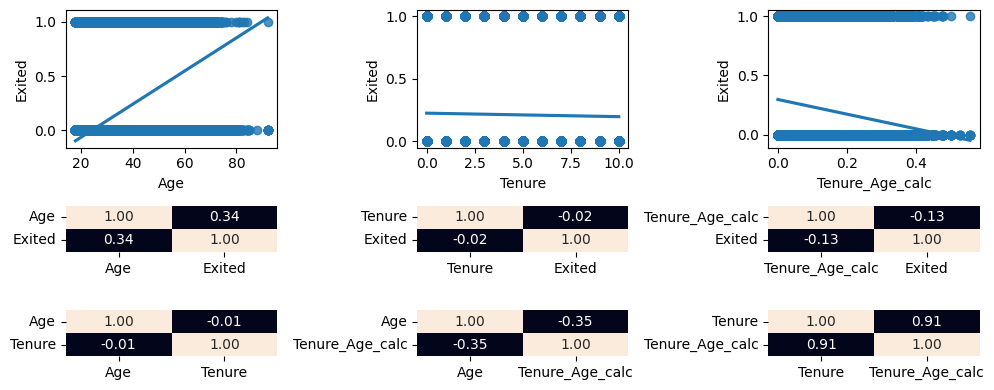

In [18]:

fig, axis = plt.subplots(3,3, figsize=(10, 4),gridspec_kw= {'height_ratios': [6, 2,2]})
sns.regplot(data = data_clean, x = "Age",y="Exited",ax=axis[0,0])
sns.regplot(data = data_clean, x = "Tenure",y="Exited",ax=axis[0,1])
sns.regplot(data = data_clean, x = "Tenure_Age_calc",y="Exited",ax=axis[0,2])

sns.heatmap(data_clean[["Age", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,0])
sns.heatmap(data_clean[["Tenure", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,1])
sns.heatmap(data_clean[["Tenure_Age_calc", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,2])

sns.heatmap(data_clean[["Age", "Tenure"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,0])
sns.heatmap(data_clean[["Age", "Tenure_Age_calc"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,1])
sns.heatmap(data_clean[["Tenure", "Tenure_Age_calc"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,2])

fig.tight_layout()
fig.show()


Ya sabemos la relación entre Tenure_age Age y Tenure, lo que podemos observar con respecto a Exited, es que Tenure no tiene ningún tipo de correlación con ella, mientras que Age tiene una correlación alta de 0.34. La variable Tenure_Age tiene una correlación negativa de -0.13 que tiene pinta de venir por la variable Age por la correlación existente entre ambas.

Por tanto, **descartamos la variable Tenure_Age** como significativa de momento, si necesitamos más variables o mejorar el modelo, podría ser una variable a incluir, teniendo en mente la relación con Age.

* **Age_Tenure_product**

In [19]:
data_clean[['Age','Tenure','NumOfProducts','Age_Tenure_product']].head()

,Age,Tenure,NumOfProducts,Age_Tenure_product
0,33.0,3.0,2.0,99.0
1,33.0,1.0,2.0,33.0
2,40.0,10.0,2.0,400.0
3,34.0,2.0,1.0,68.0
4,33.0,5.0,2.0,165.0


Podemos observar que no tiene que ver con la variable NumOfProducts, que lo que significa es que es el producto entre Age y Tenure. Comprobamos lo mismo que con la variable anterior:

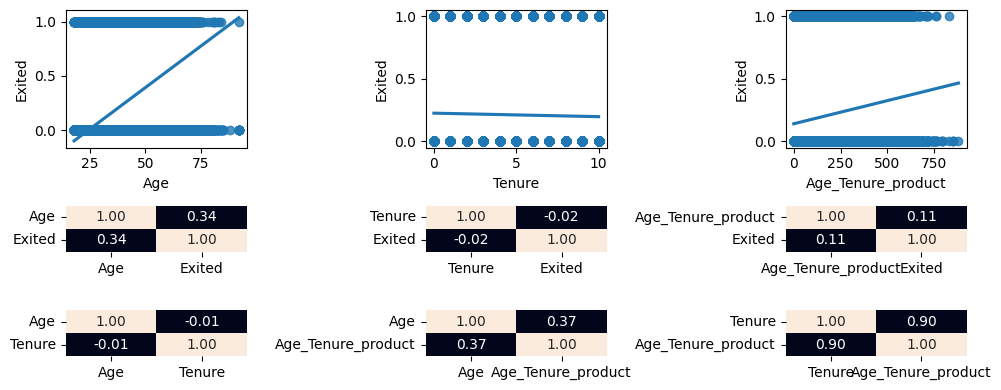

In [20]:

fig, axis = plt.subplots(3,3, figsize=(10, 4),gridspec_kw= {'height_ratios': [6, 2,2]})
sns.regplot(data = data_clean, x = "Age",y="Exited",ax=axis[0,0])
sns.regplot(data = data_clean, x = "Tenure",y="Exited",ax=axis[0,1])
sns.regplot(data = data_clean, x = "Age_Tenure_product",y="Exited",ax=axis[0,2])

sns.heatmap(data_clean[["Age", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,0])
sns.heatmap(data_clean[["Tenure", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,1])
sns.heatmap(data_clean[["Age_Tenure_product", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,2])

sns.heatmap(data_clean[["Age", "Tenure"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,0])
sns.heatmap(data_clean[["Age", "Age_Tenure_product"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,1])
sns.heatmap(data_clean[["Tenure", "Age_Tenure_product"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,2])

fig.tight_layout()
fig.show()

Las conclusiones son las mismas que con la variable Tenure_Age_calc. 

* **Mem__no__Products**

In [21]:
data_clean[['IsActiveMember','NumOfProducts','Mem__no__Products']].head()

,IsActiveMember,NumOfProducts,Mem__no__Products
0,0,2.0,0.0
1,1,2.0,2.0
2,0,2.0,0.0
3,1,1.0,1.0
4,1,2.0,2.0


En este caso, la variable Mem__no__Products= IsActiveMember*NumOfProducts. Analizamos igual que las anteriores

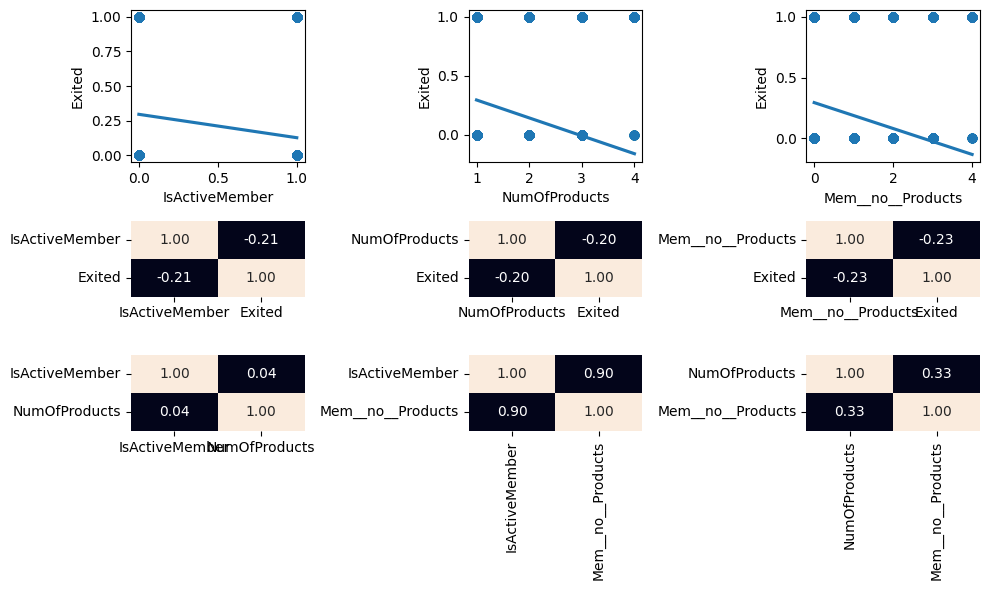

In [22]:

fig, axis = plt.subplots(3,3, figsize=(10, 6),gridspec_kw= {'height_ratios': [10, 5,5]})
sns.regplot(data = data_clean, x = "IsActiveMember",y="Exited",ax=axis[0,0])
sns.regplot(data = data_clean, x = "NumOfProducts",y="Exited",ax=axis[0,1])
sns.regplot(data = data_clean, x = "Mem__no__Products",y="Exited",ax=axis[0,2])

sns.heatmap(data_clean[["IsActiveMember", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,0])
sns.heatmap(data_clean[["NumOfProducts", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,1])
sns.heatmap(data_clean[["Mem__no__Products", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,2])

sns.heatmap(data_clean[["IsActiveMember", "NumOfProducts"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,0])
sns.heatmap(data_clean[["IsActiveMember", "Mem__no__Products"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,1])
sns.heatmap(data_clean[["NumOfProducts", "Mem__no__Products"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,2])

fig.tight_layout()
fig.show()

En este caso, las variables NumOfProducts y IsActiveMember no tienen ninguna relación entre ellas, mientras que con respecto a la variable objetivo están correlacionadas de manera negativa -0.20 y -0.21 respectivamente. Y con la variable Mem_no_Products está correlacionada en -0.23. 

Esto significa que tienen prácticamente la misma correlación por separado cada una, como si las juntamos. 
Podemos incluir en el modelo las variables por separado, o bien únicamente la variable combinación si necesitáramos reducir dimensiones. En este caso, no tenemos un exceso de variables, por tanto, **mantenemos las variables NumOfProducts y IsActiveMember** por separado y **descartamos Mem_no_Products** de momento, a la espera de ver si mejoraría el modelo. 

Transformación de variables object a numéricas:

Al transformar las variables object a numéricas se generan muchos NaN como hemos visto con la variable Tenure_Age, por tanto, hay que comprobar Cred_Bal_Sal y Bal_Sal, y EstimatedSalary para ver que no genere muchos NaN:

In [23]:
total_data_numeric = data_clean.apply(pd.to_numeric, errors='coerce')

pd.DataFrame({
    "Count_NaN": total_data_numeric[["Cred_Bal_Sal","Bal_sal","EstimatedSalary"]].isna().sum(),
    "%_NaN": round(total_data_numeric[["Cred_Bal_Sal","Bal_sal","EstimatedSalary"]].isna().sum()/total_data_numeric[["Cred_Bal_Sal","Bal_sal","EstimatedSalary"]].isna().count()*100,2)})


,Count_NaN,%_NaN
Cred_Bal_Sal,81738,46.71
Bal_sal,81737,46.71
EstimatedSalary,2,0.00


La variable EstimatedSalary contiene 2 valores que no se pueden transformar a número, vemos en la tabla5 que esos valores corresponden con dos valores de Exited=0.

Tabla5:

In [24]:
data_clean[total_data_numeric["EstimatedSalary"].isna()]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Age_Tenure_product,Sex,Countries,Tenure_Age_calc
53856,687.0,50.0,6.0,0.00,2.0,0,1,38.190.168,0,2.0,0.0,0.0,300.0,1,1,0.120000
159796,602.0,36.0,7.0,133800.98,2.0,1,0,14.012.017,0,0.0,"5.748.507.867.211.400,00","9.549.016.390.716.620,00",252.0,1,1,0.194444


Por tanto, directamente los eliminamos del dataset:

In [25]:
data_clean["EstimatedSalary"]=data_clean["EstimatedSalary"].apply(pd.to_numeric, errors='coerce')
data_clean = data_clean.dropna(subset=['EstimatedSalary'])
data_clean[total_data_numeric["EstimatedSalary"].isna()]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Age_Tenure_product,Sex,Countries,Tenure_Age_calc


In [26]:
data_clean["EstimatedSalary"].info()

<class 'pandas.core.series.Series'>
Index: 174985 entries, 0 to 175027
Series name: EstimatedSalary
Non-Null Count   Dtype  
--------------   -----  
174985 non-null  float64
dtypes: float64(1)
memory usage: 2.7 MB


Vemos que se generan muchos Nan en las variables Cred Bal Sal y Bal Sal, las analizamos por separado como Tenure_Age para ver cómo están calculadas y calcularlas de nuevo:

In [27]:
data_clean[["CreditScore","Balance","EstimatedSalary","Cred_Bal_Sal","Bal_sal"]].head()

,CreditScore,Balance,EstimatedSalary,Cred_Bal_Sal,Bal_sal
0,668.0,0.00,181449.97,0.0,0.0
1,627.0,0.00,49503.50,0.0,0.0
2,678.0,0.00,184866.69,0.0,0.0
3,581.0,148882.54,84560.88,"10.229.405.812.711.500,00","17.606.550.452.171.200,00"
4,716.0,0.00,15068.83,0.0,0.0


Tiene pinta de ser un producto de las variables, lo comprobamos y vemos que no corresponde, por tanto, probamos con la siguiente combinación posible: CreditScore*Balance/EstimatedSalary y Balance/EstimatedSalary. 

Esa es la combinación (ver tabla6), por tanto, eliminamos las columnas que no se pueden transformar y dejamos las calculadas para los análisis:

Tabla6:

In [28]:
df=pd.DataFrame({
    "Cred_Bal_Sal_calc": data_clean["CreditScore"]*data_clean["Balance"]/data_clean["EstimatedSalary"],
    "Bal_sal_calc": data_clean["Balance"]/data_clean["EstimatedSalary"]

})
subset_data_clean=data_clean[["CreditScore","Balance","EstimatedSalary","Cred_Bal_Sal","Bal_sal"]]

result = pd.concat([subset_data_clean, df], ignore_index=False,axis=1)
result.head(10)


,CreditScore,Balance,EstimatedSalary,Cred_Bal_Sal,Bal_sal,Cred_Bal_Sal_calc,Bal_sal_calc
0,668.0,0.00,181449.97,0.0,0.0,0.000000,0.000000
1,627.0,0.00,49503.50,0.0,0.0,0.000000,0.000000
2,678.0,0.00,184866.69,0.0,0.0,0.000000,0.000000
3,581.0,148882.54,84560.88,"10.229.405.812.711.500,00","17.606.550.452.171.200,00",1022.940581,1.760655
4,716.0,0.00,15068.83,0.0,0.0,0.000000,0.000000
5,588.0,131778.58,136024.31,"569.646.742.115.435,00","9.687.869.763.867.940,00",569.646742,0.968787
6,593.0,144772.69,29792.11,"2.881.642.326.441.460,00","4.859.430.567.354.910,00",2881.642326,4.859431
7,678.0,138476.41,106851.60,"8.786.672.916.456.090,00","12.959.694.567.044.300,00",878.667292,1.295969
8,676.0,0.00,142917.13,0.0,0.0,0.000000,0.000000
9,583.0,81274.33,170843.07,"2.773.477.109.138.810,00","47.572.506.160.185.400,00",277.347711,0.475725


In [29]:
data_clean["Cred_Bal_Sal_calc"]= data_clean["CreditScore"]*data_clean["Balance"]/data_clean["EstimatedSalary"]
data_clean["Bal_sal_calc"]= data_clean["Balance"]/data_clean["EstimatedSalary"]
data_clean.drop(["Cred_Bal_Sal","Bal_sal"],axis=1,inplace=True)
data_clean.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Mem__no__Products,Age_Tenure_product,Sex,Countries,Tenure_Age_calc,Cred_Bal_Sal_calc,Bal_sal_calc
0,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,0.0,99.0,1,1,0.090909,0.000000,0.000000
1,627.0,33.0,1.0,0.00,2.0,1,1,49503.50,0,2.0,33.0,1,1,0.030303,0.000000,0.000000
2,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,0.0,400.0,1,1,0.250000,0.000000,0.000000
3,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,1.0,68.0,1,1,0.058824,1022.940581,1.760655
4,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,2.0,165.0,1,3,0.151515,0.000000,0.000000


Seguimos analizando el siguiente bloque de variables independendientes ( CreditScore, Balance, Countries,EstimatedSalary) y después analizaremos las nuevas variables creadas con sus combinaciones ( Cred_Bal_Sal_calc Bal_sal_calc ):

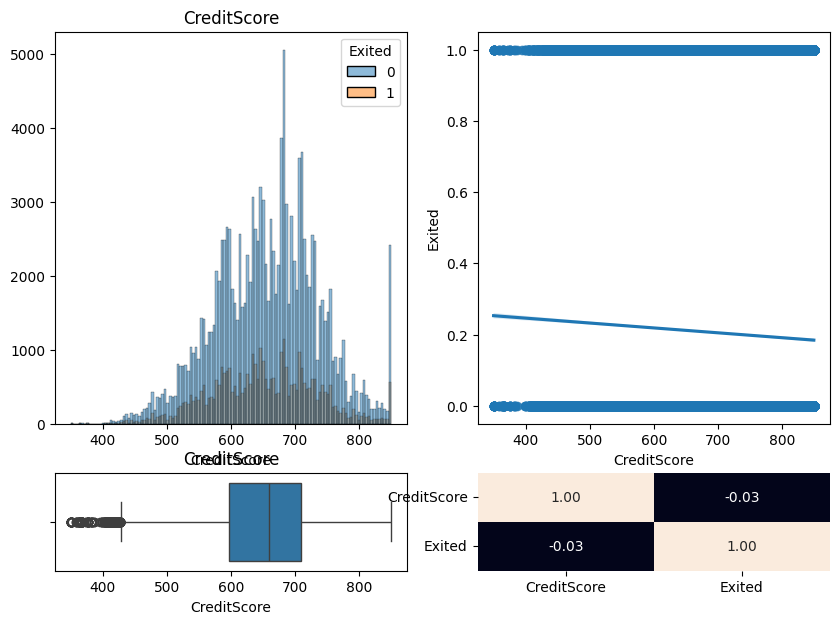

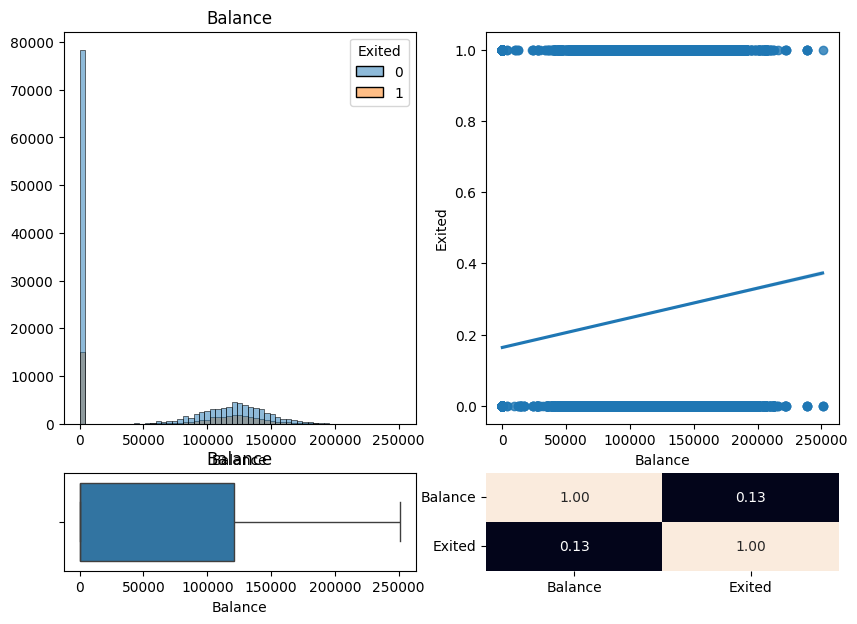

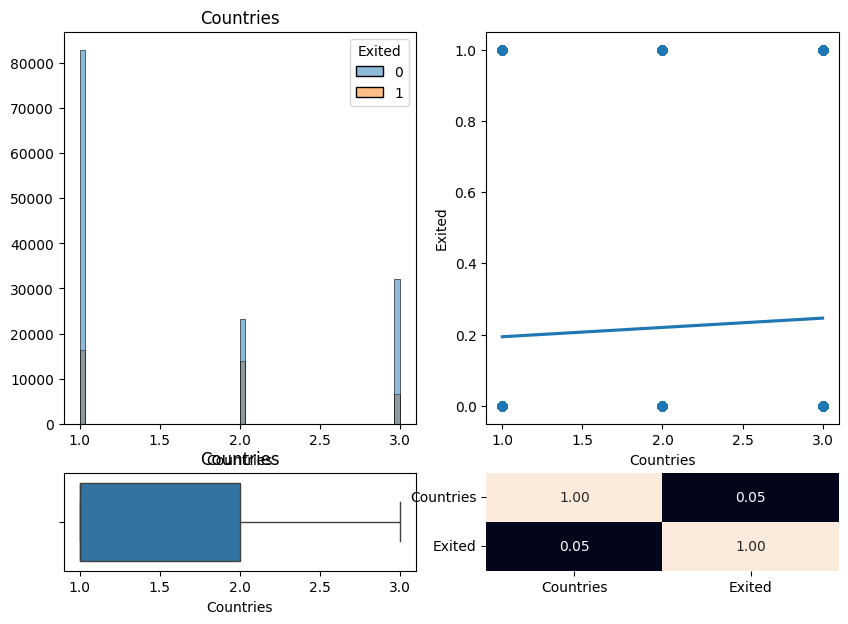

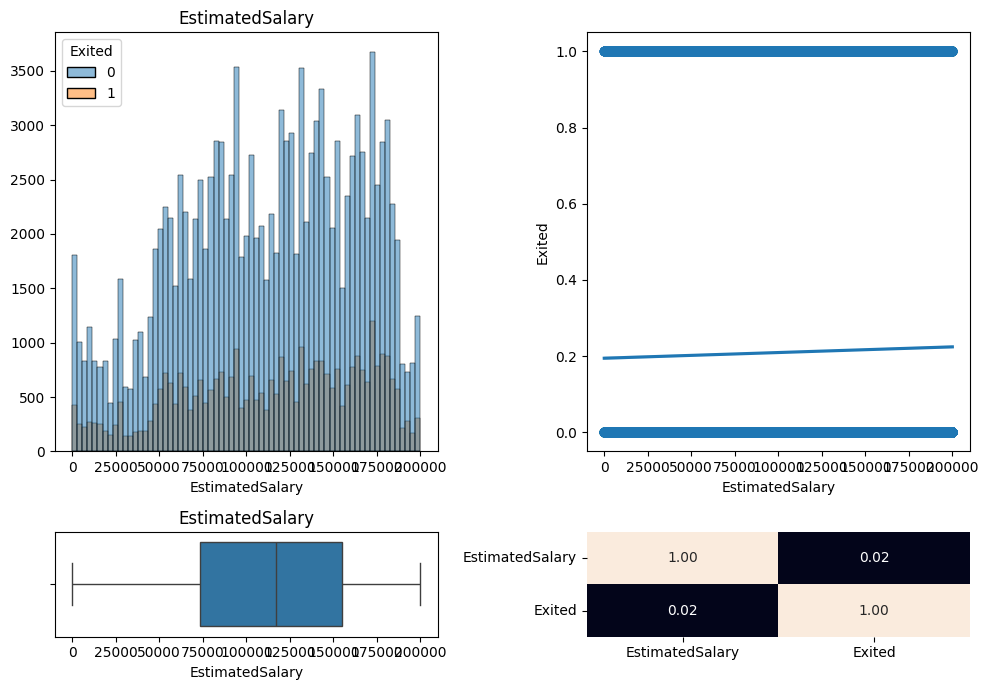

In [30]:
vars=["CreditScore","Balance","Countries","EstimatedSalary"]

for i in range(len(vars)):
    var=vars[i]
    data_clean[var] = pd.to_numeric(data_clean[var], errors='coerce')        # Para asegurar que las variables sean numéricas
    data_clean['Exited'] = pd.to_numeric(data_clean['Exited'], errors='coerce')
    
    fig, axis = plt.subplots(2, 2, figsize=(10, 7), gridspec_kw={'height_ratios': [4, 1]})
    axis[0, 0].set_title(var)
    sns.histplot(ax=axis[0, 0], data=data_clean, x=var, hue="Exited").set(ylabel=None)
    axis[1, 0].set_title(var)
    sns.regplot(data=data_clean, x=var, y="Exited", ax=axis[0, 1])
    sns.boxplot(ax=axis[1, 0], data=data_clean, x=var)
    sns.heatmap(data_clean[[var, "Exited"]].corr(), annot=True, fmt=".2f", cbar=False, ax=axis[1, 1])
    
plt.tight_layout()
plt.show()

ANÁLISIS DE LAS VARIABLES ARRIBA GRAFICADAS

CREDITSCORE

Es una medida numérica que evalúa la solvencia crediticia de una persona. Representa la evaluación de la capacidad de un individuo para cumplir con las obligaciones crediticias. Cuanto mayor sea la puntuación, mayor será la solvencia crediticia.Al observar el histograma, encontramos muchos valores atípicos por debajo de 500 y por lo tanto no estarían en la franja estimada. En este caso, una correlación del -0,03 indica que no hay una relación fuerte ni positiva ni negativa entre la puntuación de crédito (CreditScore) y la variable de abandono (Exited). Puede interpretarse como que, en términos lineales, la puntuación de crédito no tiene una influencia significativa en la probabilidad de que un cliente abandone el servicio.

BALANCE

Se refiere a la cantidad de dinero en una cuenta o la diferencia entre los ingresos y los gastos. En el contexto financiero, puede indicar el saldo de una cuenta bancaria, tarjeta de crédito o cualquier otro instrumento financiero. El 0.13 indica una correlación positiva débil. A medida que la variable Balance aumenta, hay una ligera tendencia a que también aumente la variable Exited, y viceversa. Es importante tener en cuenta que una correlación débil no implica causalidad. En otras palabras, la correlación no indica necesariamente que un mayor saldo (balance) cause que un cliente abandone o no el servicio.

COUNTRIES

En esta variables donde está definida los tres paises (Francia, Alemania y España) se puede observar que al comparar en el gráfico un 0.05 indica una correlación positiva extremadamente débil. No hay una relación fuerte entre la variable Countries y Exited, en términos de una relación lineal simple, tal y como hemos clasificado los países. Sin embargo, podemos ver que el % de abandono en Alemania es más del doble que en el resto de los países (ver tabla7 y Grafico1), por tanto, es una variable a tener en cuenta en el modelo.

ESTIMATEDSALARY

Representa la estimación del salario de una persona. El 0.02% indica una correlación positiva extremadamente débil. No hay una relación fuerte entre la variable EstimatedSalary y Exited. Esta baja correlación sugiere que la variable EstimatedSalary y la probabilidad de que un cliente abandone (variable Exited) no están fuertemente relacionadas linealmente. En términos simples, la variación en EstimatedSalary no predice de manera efectiva la variación en Exited de acuerdo con una relación lineal

Tabla7:

In [31]:
percentaje=(data_clean.groupby('Countries')['Exited'].count()/len(data_clean['Exited']))*100
churn=(data_clean.groupby("Countries")["Exited"].sum()/data_clean.groupby("Countries")["Exited"].count())*100

print(pd.DataFrame({
    'Countries':['France','Germany','Spain'],
    '%': round(percentaje,2) ,
    '% Churn': round(churn,2)
    
}))

          Countries      %  % Churn
Countries                          
1            France  56.69    16.51
2           Germany  21.21    37.53
3             Spain  22.10    17.19


Grafico1: Veámoslo gráficamente:

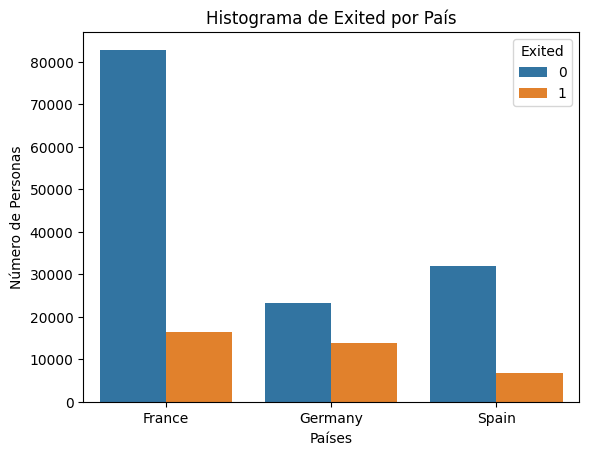

In [32]:
# Crear un mapeo de etiquetas para los países
country_labels = {1: 'France', 2: 'Germany', 3: 'Spain'}

# Mapear los valores de 'Countries' a las etiquetas correspondientes
data_clean['Country_Labels'] = data_clean['Countries'].map(country_labels)

# Crear un histograma de barras comparando 'Country_Labels' y 'Exited'
sns.countplot(data=data_clean.sort_values('Country_Labels'), x='Country_Labels', hue='Exited')

# Ajustar leyendas y etiquetas
plt.title('Histograma de Exited por País')
plt.xlabel('Países')
plt.ylabel('Número de Personas')

# Mostrar el gráfico
plt.show()

Análisis variables combinadas: Cred_Bal_Sal_calc, Bal_sal_calc:

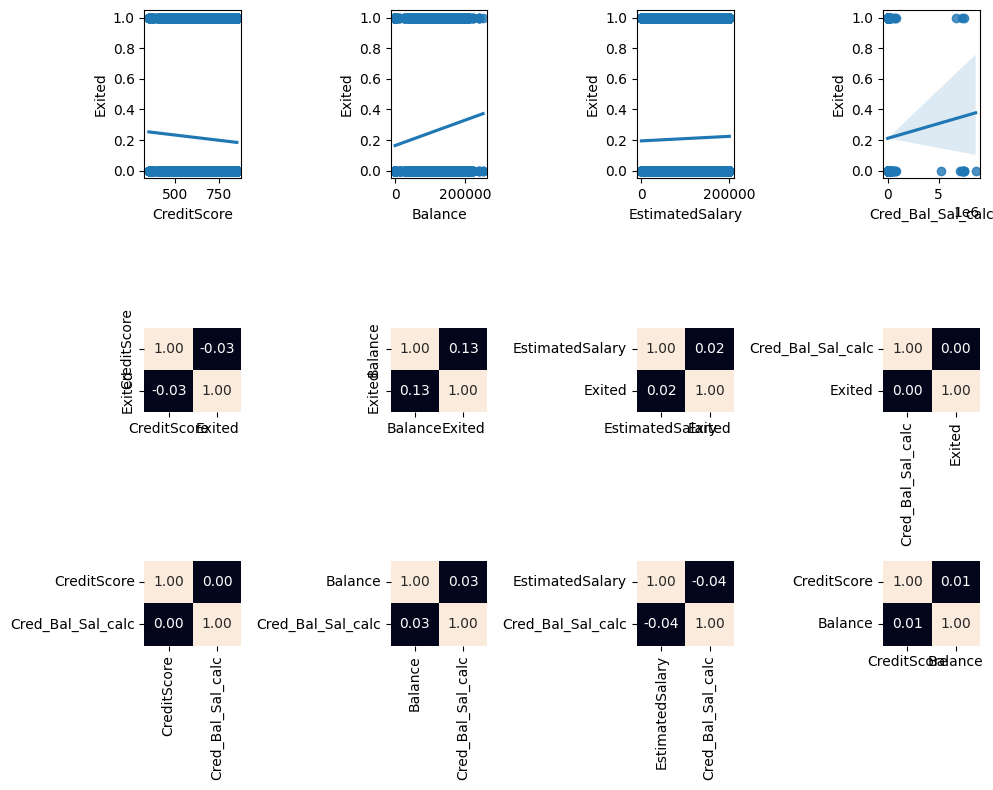

In [33]:
fig, axis = plt.subplots(3,4, figsize=(10, 8),gridspec_kw= {'height_ratios': [8,4,4]})
sns.regplot(data = data_clean, x = "CreditScore",y="Exited",ax=axis[0,0])
sns.regplot(data = data_clean, x = "Balance",y="Exited",ax=axis[0,1])
sns.regplot(data = data_clean, x = "EstimatedSalary",y="Exited",ax=axis[0,2])
sns.regplot(data = data_clean, x = "Cred_Bal_Sal_calc",y="Exited",ax=axis[0,3])

sns.heatmap(data_clean[["CreditScore", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,0])
sns.heatmap(data_clean[["Balance", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,1])
sns.heatmap(data_clean[["EstimatedSalary", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,2])
sns.heatmap(data_clean[["Cred_Bal_Sal_calc", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,3])

sns.heatmap(data_clean[["CreditScore", "Cred_Bal_Sal_calc"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,0])
sns.heatmap(data_clean[["Balance", "Cred_Bal_Sal_calc"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,1])
sns.heatmap(data_clean[["EstimatedSalary", "Cred_Bal_Sal_calc"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,2])
sns.heatmap(data_clean[["CreditScore", "Balance"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,3])


fig.tight_layout()
fig.show()

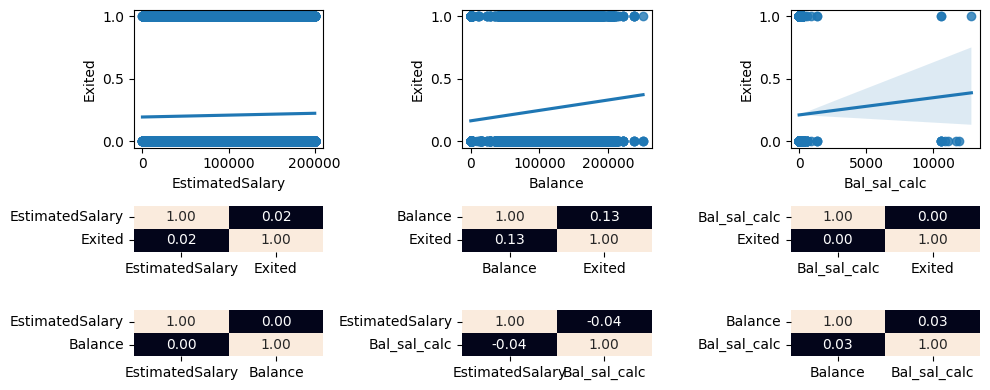

In [34]:
fig, axis = plt.subplots(3,3, figsize=(10, 4),gridspec_kw= {'height_ratios': [6, 2,2]})
sns.regplot(data = data_clean, x = "EstimatedSalary",y="Exited",ax=axis[0,0])
sns.regplot(data = data_clean, x = "Balance",y="Exited",ax=axis[0,1])
sns.regplot(data = data_clean, x = "Bal_sal_calc",y="Exited",ax=axis[0,2])

sns.heatmap(data_clean[["EstimatedSalary", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,0])
sns.heatmap(data_clean[["Balance", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,1])
sns.heatmap(data_clean[["Bal_sal_calc", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,2])

sns.heatmap(data_clean[["EstimatedSalary", "Balance"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,0])
sns.heatmap(data_clean[["EstimatedSalary", "Bal_sal_calc"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,1])
sns.heatmap(data_clean[["Balance", "Bal_sal_calc"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[2,2])

fig.tight_layout()
fig.show()

Al observar las dos partes de gráficos comparando las variables independientes con als combinadas respecto a 'Excited' comprobamos que una correlación del 0.00 entre las variables Cred_Bal_Sal_calc y Bal_sal_calc con la variable Exited indica que no hay una relación lineal aparente entre estas variables y la probabilidad de que un cliente abandone (Exited).

Esto significa que, según el análisis de correlación lineal, no hay una relación sistemática y lineal entre la combinación de CreditScore * Balance / EstimatedSalary (representada por Cred_Bal_Sal_calc) o Balance / EstimatedSalary (representada por Bal_sal_calc) y la variable objetivo Exited.

Vamos a analizar estas variables calculadas por separado para ver outliers:

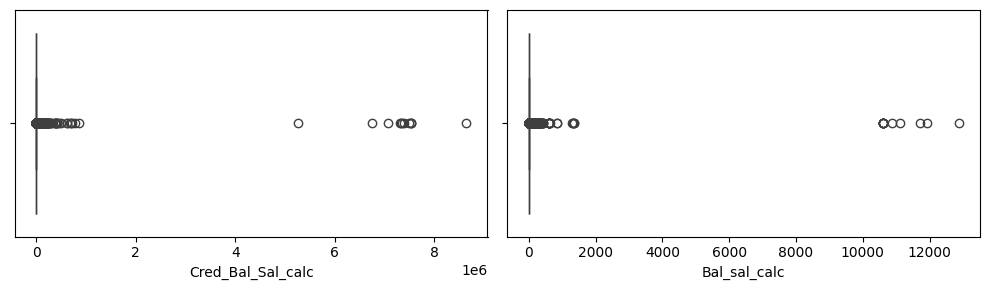

In [35]:
fig, axis = plt.subplots(1,2,figsize=(10,3))
sns.boxplot(data=data_clean, x="Cred_Bal_Sal_calc",ax=axis[0])
sns.boxplot(data=data_clean, x="Bal_sal_calc",ax=axis[1])
plt.tight_layout()
plt.show()


Podemos observar que en ambos casos hay una existencia de outliers que distorsionan las distribuciones de las variables. Los visualizamos en los siguientes graficos:

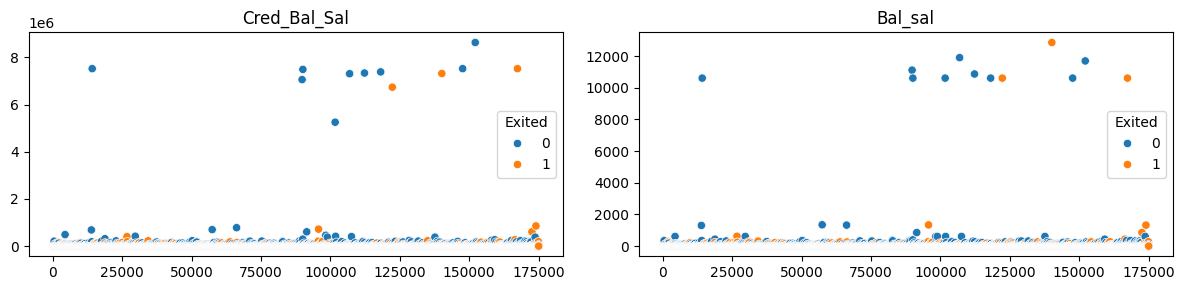

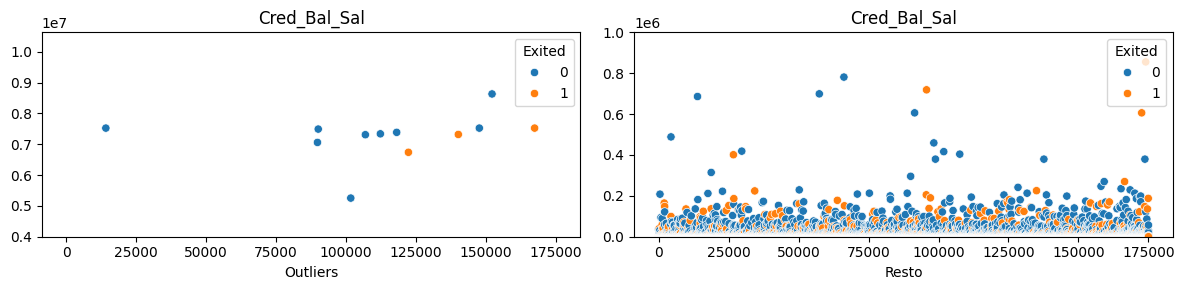

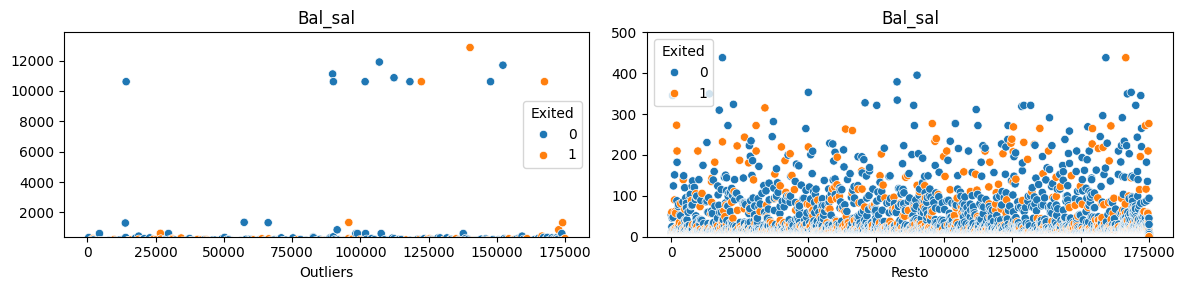

In [36]:
categoria= data_clean['Exited'].astype('category')

fig, axis= plt.subplots(1,2,figsize=(12,3))
max1=data_clean["Cred_Bal_Sal_calc"].max()+2000000
min1=data_clean["Cred_Bal_Sal_calc"].min()
max2=data_clean["Bal_sal_calc"].max()+1000
min2=data_clean["Bal_sal_calc"].min()

sns.scatterplot(x=data_clean["Cred_Bal_Sal_calc"].index,y=data_clean["Cred_Bal_Sal_calc"],hue=categoria,ax=axis[0]).set_ylabel
sns.scatterplot(x=data_clean["Bal_sal_calc"].index,y=data_clean["Bal_sal_calc"],hue=categoria,ax=axis[1])
axis[0].set_xlabel("")
axis[0].set_title("Cred_Bal_Sal")
axis[0].set_ylabel("")
axis[1].set_xlabel("")
axis[1].set_ylabel("")
axis[1].set_title("Bal_sal")
plt.tight_layout()

plt.show()

fig, axis= plt.subplots(1,2,figsize=(12,3))
sns.scatterplot(x=data_clean["Cred_Bal_Sal_calc"].index,y=data_clean["Cred_Bal_Sal_calc"],hue=categoria,ax=axis[0])
axis[0].set_ylim(4000000,max1)
axis[0].set_title("Cred_Bal_Sal")
#axis[0].set_yticklabels([])
sns.scatterplot(x=data_clean["Cred_Bal_Sal_calc"].index,y=data_clean["Cred_Bal_Sal_calc"],hue=categoria,ax=axis[1])
axis[1].set_ylim(min1,1000000)
axis[1].set_title("Cred_Bal_Sal")
#axis[1].set_yticks([])
#axis[1].set_yticklabels([])
axis[0].set_xlabel("Outliers")
axis[0].set_ylabel("")
axis[1].set_xlabel("Resto")
axis[1].set_ylabel("")

#plt.yticks([])
plt.tight_layout()

plt.show()

fig, axis= plt.subplots(1,2,figsize=(12,3))
sns.scatterplot(x=data_clean["Bal_sal_calc"].index,y=data_clean["Bal_sal_calc"],hue=categoria,ax=axis[0])
axis[0].set_ylim(400,max2)
axis[0].set_title("Bal_sal")
#axis[0].set_yticklabels([])
sns.scatterplot(x=data_clean["Bal_sal_calc"].index,y=data_clean["Bal_sal_calc"],hue=categoria,ax=axis[1])
axis[1].set_ylim(min2,500)
axis[1].set_title("Bal_sal")
#axis[1].set_yticks([])
#axis[1].set_yticklabels([])
axis[0].set_xlabel("Outliers")
axis[0].set_ylabel("")
axis[1].set_xlabel("Resto")
axis[1].set_ylabel("")

#plt.yticks([])
plt.tight_layout()
plt.show()

Podemos observar que los outliers contienen algunos datos de abandonos, y tienen pinta de ser el mismo cliente, por tanto, vamos a llevar esos outliers a la media. 

La media, a pesar de tener estas dos variables más del 50% de los datos en 0, es una media elevada en el caso de Cred_Bal_Sal, debido a la diferencia de rango de los outliers que distorsionan esa media. En este caso, nos viene bien que la media sea ese valor para no llevar a los outliers a un valor demasiado pequeño. 

En el caso de Bal_sal observamos que el número de outliers es muy bajo (menos de un 0,1%), vamos a trabajar con un 1% de los outliers de Cred_Bal_Sal y un 0,1% de los de Bal_sal y a ver si con esos ya tenemos una distribución más homogénea.

Tabla8

In [37]:
# Calcula los percentiles adicionales
percentiles = [0.9, 0.95,0.99,0.999]
additional_perc1 = data_clean["Bal_sal_calc"].quantile(percentiles)
additional_perc2 = data_clean["Cred_Bal_Sal_calc"].quantile(percentiles)

# Combina los resultados de describe() con los percentiles adicionales
describe_with_perc1 = data_clean["Bal_sal_calc"].describe()
describe_with_perc1.loc["90%"] = additional_perc1.loc[0.90]
describe_with_perc1.loc["95%"] = additional_perc1.loc[0.95]
describe_with_perc1.loc["99%"] = additional_perc1.loc[0.99]
describe_with_perc1.loc["99,9%"] = additional_perc1.loc[0.999]

describe_with_perc2 = data_clean["Cred_Bal_Sal_calc"].describe()
describe_with_perc2.loc["90%"] = additional_perc2.loc[0.90]
describe_with_perc2.loc["95%"] = additional_perc2.loc[0.95]
describe_with_perc2.loc["99%"] = additional_perc2.loc[0.99]
describe_with_perc2.loc["99,9%"] = additional_perc2.loc[0.999]

info_combined = pd.concat([describe_with_perc2.round(3), describe_with_perc1.round(3)], axis=1)

print(info_combined)

       Cred_Bal_Sal_calc  Bal_sal_calc
count         174985.000    174985.000
mean            1444.306         2.202
std            60979.725        92.691
min                0.000         0.000
25%                0.000         0.000
50%                0.000         0.000
75%              658.642         1.000
max          8634204.107     12863.796
90%             1213.756         1.845
95%             1854.949         2.790
99%            10523.192        15.997
99,9%         114751.142       173.563


In [39]:
quant=np.arange(0.90, 1, 0.01)

mean1=data_clean["Cred_Bal_Sal_calc"].mean()
mean2=data_clean["Bal_sal_calc"].mean()
corr1=[]
per1=[]
corr2=[]
per2=[]
for i in range(len(quant)):
    per1.append(data_clean["Cred_Bal_Sal_calc"].quantile(quant[i]))
    data_clean["Cred_Bal_Sal_out"]= data_clean["Cred_Bal_Sal_calc"].apply(lambda x: x if x <= per1[i] else mean1)
    corr1.append(data_clean["Cred_Bal_Sal_out"].corr(data_clean["Exited"]))

for i in range(len(quant)):
    per2.append(data_clean["Bal_sal_calc"].quantile(quant[i]))
    data_clean["Bal_sal_out"]= data_clean["Bal_sal_calc"].apply(lambda x: x if x <= per2[i] else mean2)
    corr2.append(data_clean["Bal_sal_out"].corr(data_clean["Exited"]))


NameError: name 'quant2' is not defined

In [ ]:
fig, axis = plt.subplots(1,2,figsize=(10,2))
sns.scatterplot(x=per1,y=corr1,ax=axis[0])
axis[0].set_xticks(per1, labels=(quant*100).round(3), rotation=90,fontsize=8)
axis[0].set_title("Cred_Bal_Sal")

sns.scatterplot(x=per2,y=corr2,ax=axis[1])
axis[1].set_xticks(per2, labels=(quant*100).round(3), rotation=90,fontsize=8)
axis[1].set_title("Bal_Sal")
plt.show()

In [ ]:
print(f"'Cred_Bal_Sal' maxima correlación: {max(corr1).round(3)} en percentil: {quant[corr1.index(max(corr1))]}")
print(f"'Bal_sal' maxima correlación: {max(corr2).round(3)} en percentil: {quant[corr2.index(max(corr2))]}")

In [ ]:
quant=np.arange(0.92, 0.99, 0.01)

mean1=data_clean["Cred_Bal_Sal_calc"].mean()
mean2=data_clean["Bal_sal_calc"].mean()
corr1=[]
per1=[]
corr2=[]
per2=[]
for i in range(len(quant)):
    per1.append(data_clean["Cred_Bal_Sal_calc"].quantile(quant[i]))
    data_clean["Cred_Bal_Sal_out"]= data_clean["Cred_Bal_Sal_calc"].apply(lambda x: x if x <= per1[i] else mean1)
    corr1.append(data_clean["Cred_Bal_Sal_out"].corr(data_clean["Exited"]))

for i in range(len(quant)):
    per2.append(data_clean["Bal_sal_calc"].quantile(quant[i]))
    data_clean["Bal_sal_out"]= data_clean["Bal_sal_calc"].apply(lambda x: x if x <= per2[i] else mean2)
    corr2.append(data_clean["Bal_sal_out"].corr(data_clean["Exited"]))

In [ ]:
fig, axis = plt.subplots(1,2,figsize=(10,2))
sns.scatterplot(x=per1,y=corr1,ax=axis[0])
axis[0].set_xticks(per1, labels=(quant*100).round(3), rotation=90,fontsize=8)
axis[0].set_title("Cred_Bal_Sal")

sns.scatterplot(x=per2,y=corr2,ax=axis[1])
axis[1].set_xticks(per2, labels=(quant*100).round(3), rotation=90,fontsize=8)
axis[1].set_title("Bal_Sal")
plt.show()

Sin perder mucha correlacion podriamos ir a transformar los outliers por encima del 95%:

In [ ]:
per95_1=data_clean["Cred_Bal_Sal_calc"].quantile(0.95)
data_clean["Cred_Bal_Sal_out"]= data_clean["Cred_Bal_Sal_calc"].apply(lambda x: x if x <= per95_1 else mean1)
corr_1=data_clean["Cred_Bal_Sal_out"].corr(data_clean["Exited"])

per95_2=data_clean["Bal_sal_calc"].quantile(0.95)
data_clean["Bal_sal_out"]= data_clean["Bal_sal_calc"].apply(lambda x: x if x <= per95_2 else mean2)
corr_2=data_clean["Bal_sal_out"].corr(data_clean["Exited"])

print(f"'Cred_Bal_Sal' correlación: {corr_1.round(3)} en percentil 95")
print(f"'Bal_Sal' correlación: {corr_2.round(3)} en percentil 95")



In [ ]:
fig, axis = plt.subplots(2,4, figsize=(12,7))


sns.heatmap(data_clean[["CreditScore", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[0,0])
sns.heatmap(data_clean[["Balance", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[0,1])
sns.heatmap(data_clean[["EstimatedSalary", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[0,2])
sns.heatmap(data_clean[["Cred_Bal_Sal_out", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[0,3])

sns.heatmap(data_clean[["CreditScore", "Cred_Bal_Sal_out"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,0])
sns.heatmap(data_clean[["Balance", "Cred_Bal_Sal_out"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,1])
sns.heatmap(data_clean[["EstimatedSalary", "Cred_Bal_Sal_out"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,2])
sns.heatmap(data_clean[["CreditScore", "Balance"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,3])
axis[1,0].set_xticklabels(axis[1,0].get_xticklabels(), rotation=90)
axis[1,1].set_xticklabels(axis[1,1].get_xticklabels(), rotation=90)
axis[1,2].set_xticklabels(axis[1,2].get_xticklabels(), rotation=90)
axis[1,3].set_xticklabels(axis[1,3].get_xticklabels(), rotation=90)

fig.tight_layout()
fig.show()

In [ ]:
fig, axis = plt.subplots(2,3, figsize=(12, 4))


sns.heatmap(data_clean[["Balance", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[0,0])
sns.heatmap(data_clean[["EstimatedSalary", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[0,1])
sns.heatmap(data_clean[["Bal_sal_out", "Exited"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[0,2])

sns.heatmap(data_clean[["Balance", "Bal_sal_out"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,0])
sns.heatmap(data_clean[["EstimatedSalary", "Bal_sal_out"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,1])
sns.heatmap(data_clean[["EstimatedSalary", "Balance"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,2])


fig.tight_layout()
fig.show()

Un análisis de correlación utilizando un gráfico de mapa de calor nos proporciona información valiosa sobre las relaciones entre las variables del conjunto de datos comparandolo con la variable objetivo "Excited".

Vamos a comprobar las variables independientes una a una comparándolo con la variable objetivo.

In [ ]:
fig, axis = plt.subplots(figsize=(12, 9))

# Incluir todas las columnas en el análisis de correlación
data_clean.drop("Country_Labels",axis=1,inplace=True)
sns.heatmap(data_clean.corr(), annot=True, fmt=".2f")

plt.tight_layout()
plt.show()

**Resumen** Entrada de variables en el modelo: 

* Age - **Candidata**           Correlación 0.34
* Tenure - **Descartada**       Correlación -0.01
* NumOfProducts - **Candidata**       Correlación -0.20
* IsActiveMember - **Candidata**       Correlación -0.21
* Sex - **Candidata**       Correlación -0.14
* CreditScore - **Descartada**      Correlación -0.03
* Balance - **Candidata**       Correlación 0.13
* Countries - **Candidata** Por lo explicado en Tabla7 y Grafico1
* EstimatedSalary - **Descartada**      Correlación 0.02


* Tenure_Age - **Descartada**       Correlación -0.13
* Age_Tenure_product - **Descartada**       Correlación 0.11
* Mem__no__Products - **No Candidata**       Correlación -0.23
* Cred_Bal_Sal - **No Candidata**       Correlación 0.10
* Bal_sal - **No Candidata**       Correlación 0.11